# Homework 4

## 2. Recurrent Network (NN) Classification

In [6]:
import os
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
!unzip "/content/human+activity+recognition+using+smartphones.zip"
!unzip "UCI HAR Dataset.zip"

Archive:  /content/human+activity+recognition+using+smartphones.zip
warning [/content/human+activity+recognition+using+smartphones.zip]:  51568688 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  51568688
  (attempting to re-compensate)
 extracting: UCI HAR Dataset.names   
error: not enough memory for bomb detection
unzip:  cannot find or open UCI HAR Dataset.zip, UCI HAR Dataset.zip.zip or UCI HAR Dataset.zip.ZIP.


In [3]:
# Helper function to load the raw inertial signals
def load_ucihar(data_dir="UCI HAR Dataset", subset="train"):
    """ Loads the UCI HAR data from the Inertial Signals folder. Returns: X: numpy array of shape (num_samples, seq_len, num_signals) y: numpy array of labels (0-indexed) """
    # The nine signal types available in the dataset
    signal_types = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z" ]
    signals = []
    # Each signal file is located in {data_dir}/{subset}/Inertial Signals/
    for signal in signal_types:
        filename = os.path.join(data_dir, subset, "Inertial Signals", f"{signal}_{ subset}.txt")
        # Each file has shape (num_samples, 128)
        data = np.loadtxt(filename) # Add a new axis so that we can later stack to shape (num_samples, 128, num_signals)
        signals.append(data[..., np.newaxis]) # Stack along the last dimension to form (num_samples, 128, 9)
    X = np.concatenate(signals, axis=2) # Load labels from y_{subset}.txt; labels in the dataset are 1-indexed, so subtract 1.
    y_path = os.path.join(data_dir, subset, f"y_{subset}.txt")
    y = np.loadtxt(y_path).astype(int)- 1
    return X, y

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Define a PyTorch Dataset for UCI HAR
class UCIHARDataset(Dataset):
  def __init__(self, data_dir="UCI HAR Dataset", subset="train"):
    self.X, self.y = load_ucihar(data_dir, subset)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    sample = torch.tensor(self.X[idx], dtype=torch.float32)
    label = torch.tensor(self.y[idx], dtype=torch.long)
    return sample, label

# 2.1 Recurrent Neural Networks

In [6]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

default_input_dim = 9
default_feature_dim = 16
default_num_classes = 6

# define model
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first= True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x. device)
        out, _ = self.rnn(x, h0)
        logit = self.fc(out[:,-1, :])
        prob = nn.functional.softmax(logit, dim=1)
        return prob, logit


In [7]:
num_epochs, batch_size, lr = 10, 16, 0.001

# create train, test dataset
train_dataset = UCIHARDataset(subset="train")
test_dataset = UCIHARDataset(subset="test")

#    create train, test loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle= False)

# create model, loss criterion, optimizer
model = RNNClassifier(input_size=9, hidden_size=16, num_layers=1, num_classes=6)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
def train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # start training
    for epoch in range(num_epochs):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            activity_prob, activity_logit = model(inputs)
            loss = criterion(activity_logit, labels)
            loss.backward()
            optimizer.step()

    # Evaluate on test data
    model.eval()
    test_acc = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            activity_prob, activity_logit = model(inputs)
            _, predicted = torch.max(activity_logit.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

In [9]:
# Evaluate on test data
train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.5151


## 2.2 a Feature dim to 64

In [10]:
feature_dim = 64

# create model, loss criterion, optimizer
model = RNNClassifier(input_size=9, hidden_size=feature_dim, num_layers=1, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.7370


2.2 b Experimenting with 2, 3 and 4 layers

In [11]:
feature_dim = 16
num_layers = 2

# create model, loss criterion, optimizer
model = RNNClassifier(input_size=9, hidden_size=feature_dim, num_layers=num_layers, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.6298


In [12]:
num_layers = 3

# create model, loss criterion, optimizer
model = RNNClassifier(input_size=9, hidden_size=16, num_layers=num_layers, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.6569


In [13]:
num_layers = 4

# create model, loss criterion, optimizer
model = RNNClassifier(input_size=9, hidden_size=16, num_layers=num_layers, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.5894


## 2.c Replacing RNN with LSTM

In [14]:
# Replace RNN with LSTM (feature_dim=16, num_layers=1)
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        logit = self.fc(out[:, -1, :])
        prob = nn.functional.softmax(logit, dim=1)
        return prob, logit

feature_dim = 16
num_layers = 1
input_size = 9
num_classes = 6

# create model, loss criterion, optimizer
model = LSTMClassifier(input_size=input_size, hidden_size=feature_dim, num_layers=num_layers, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model_and_test(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Test Accuracy: 0.5724


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision
import numpy as np
import time

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
class PatchEmbedding(nn.Module):
    """ Splits the image into patches and embeds them. """
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        # We use a simple conv layer to perform patchify + embedding in one step.
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        # Number of patches
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        # Positional embedding
        self.pos_emb = nn.Parameter(torch.zeros(1, num_patches + 1, emb_size))

    def forward(self, x):
        """ x shape: (B, 3, 32, 32) returns: (B, N+1, emb_size) """
        B = x.size(0)
        # Conv2d-> (B, emb_size, H’, W’), with H’ and W’ = 32 // patch_size
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        # Class token
        cls_token = self.cls_token.expand(B,-1,-1) # (B, 1, emb_size)
        x = torch.cat([cls_token, x], dim=1) # (B, N+1, emb_size)
        # Add positional embedding
        x = x + self.pos_emb[:, : x.size(1), :]
        return x

In [17]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x): # x shape: (B, N, emb_size)
        B, N, _ = x.shape
        qkv = self.qkv(x) # (B, N, 3*emb_size)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # each: (B, num_heads, N, head_dim)

        # Scaled Dot-Product Attention
        # # scores shape: (B, num_heads, N, N)
        scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = torch.softmax(scores, dim=-1)
        att = self.att_drop(att)

        # out shape: (B, num_heads, N, head_dim)
        out = torch.matmul(att, v)

        # Combine heads
        out = out.transpose(1, 2) # (B, N, num_heads, head_dim)
        out = out.flatten(2) # (B, N, emb_size)
        out = self.projection(out)

        return out

In [18]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=128, num_heads=4, expansion=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(), nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size)
            )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # Attention block
        x_res = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x_res + self.drop(x)

        # Feed-forward block
        x_res = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = x_res + self.drop(x)
        return x

In [19]:
class VisionTransformer(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32, num_heads=4, num_layers=6, num_classes=10, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                emb_size=emb_size,
                num_heads=num_heads,
                expansion=4,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(emb_size)
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        # x shape: (B, 3, 32, 32)
        x = self.patch_embed(x) # (B, N+1, emb_size)
        x = self.encoder(x) # (B, N+1, emb_size)
        x = self.norm(x) # (B, N+1, emb_size)

        # The first token is the class token
        cls_token_final = x[:, 0]
        out = self.cls_head(cls_token_final) # (B, num_classes)
        return out

In [20]:
# Load CIFAR-10 dataset
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), # Mean for each channel
                         (0.2470, 0.2435, 0.2616)) # Std for each channel
                         ])

batch_size_cifar = 64
lr_cifar = 0.001
num_epochs_cifar = 20

cifar_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=batch_size_cifar, shuffle=True)
cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=batch_size_cifar, shuffle=False)

# Train ViT with default configuration on CIFAR-10
vit_model = VisionTransformer().to(device)
vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=lr_cifar)


100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Training ViT with default configuration...
Epoch 01/20  train_loss=1.7063  train_acc=0.3638  test_acc=0.4556
Epoch 02/20  train_loss=1.4271  train_acc=0.4791  test_acc=0.5187
Epoch 03/20  train_loss=1.3149  train_acc=0.5210  test_acc=0.5541
Epoch 04/20  train_loss=1.2469  train_acc=0.5468  test_acc=0.5540
Epoch 05/20  train_loss=1.1975  train_acc=0.5623  test_acc=0.5691
Epoch 06/20  train_loss=1.1523  train_acc=0.5843  test_acc=0.5608
Epoch 07/20  train_loss=1.1123  train_acc=0.5990  test_acc=0.5929
Epoch 08/20  train_loss=1.0772  train_acc=0.6082  test_acc=0.5946
Epoch 09/20  train_loss=1.0496  train_acc=0.6175  test_acc=0.6004
Epoch 10/20  train_loss=1.0202  train_acc=0.6298  test_acc=0.6143
Epoch 11/20  train_loss=0.9905  train_acc=0.6427  test_acc=0.6234
Epoch 12/20  train_loss=0.9609  train_acc=0.6501  test_acc=0.6198
Epoch 13/20  train_loss=0.9350  train_acc=0.6630  test_acc=0.6345
Epoch 14/20  train_loss=0.9114  train_acc=0.6696  test_acc=0.6272
Epoch 15/20  train_loss=0.8884  t

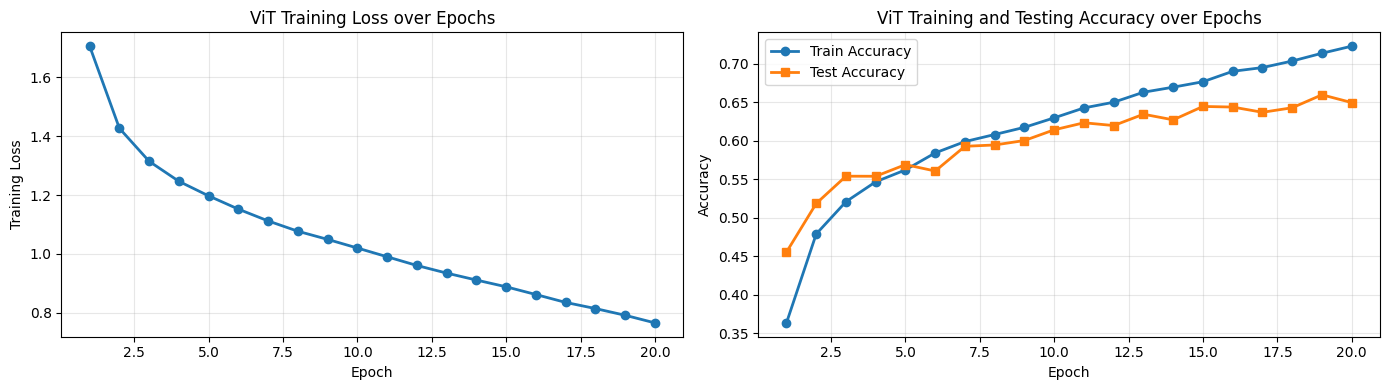


ViT Final Results:
Final Train Accuracy: 0.7228
Final Test Accuracy: 0.6496


In [21]:
print("Training ViT with default configuration...")
vit_train_losses = []
vit_train_accs = []
vit_test_accs = []
for epoch in range(num_epochs_cifar):
    vit_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in cifar_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        vit_optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = vit_criterion(outputs, labels)
        loss.backward()
        vit_optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    vit_train_losses.append(train_loss)
    vit_train_accs.append(train_acc)

    # Evaluate on test set
    vit_model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in cifar_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_model(inputs)
            _, preds = outputs.max(1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    vit_test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs_cifar}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")

# Plot results
epochs_range = np.arange(1, num_epochs_cifar + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot training loss
axes[0].plot(epochs_range, vit_train_losses, marker='o', linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("ViT Training Loss over Epochs")
axes[0].grid(True, alpha=0.3)

# Plot training and testing accuracy
axes[1].plot(epochs_range, vit_train_accs, marker='o', linewidth=2, label="Train Accuracy")
axes[1].plot(epochs_range, vit_test_accs, marker='s', linewidth=2, label="Test Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("ViT Training and Testing Accuracy over Epochs")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nViT Final Results:")
print(f"Final Train Accuracy: {vit_train_accs[-1]:.4f}")
print(f"Final Test Accuracy: {vit_test_accs[-1]:.4f}")

In [22]:
print(len(vit_train_losses))
print(epochs_range)

20
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]



Training ViT with learning rate = 0.01
Epoch 01/20  train_loss=2.1861  train_acc=0.1690  test_acc=0.1663
Epoch 02/20  train_loss=2.1964  train_acc=0.1601  test_acc=0.1575
Epoch 03/20  train_loss=2.2429  train_acc=0.1446  test_acc=0.1534
Epoch 04/20  train_loss=2.2187  train_acc=0.1533  test_acc=0.1817
Epoch 05/20  train_loss=2.2046  train_acc=0.1595  test_acc=0.1398
Epoch 06/20  train_loss=2.1813  train_acc=0.1692  test_acc=0.1641
Epoch 07/20  train_loss=2.1872  train_acc=0.1725  test_acc=0.1783
Epoch 08/20  train_loss=2.1876  train_acc=0.1666  test_acc=0.1807
Epoch 09/20  train_loss=2.1863  train_acc=0.1748  test_acc=0.1620
Epoch 10/20  train_loss=2.1673  train_acc=0.1795  test_acc=0.1675
Epoch 11/20  train_loss=2.1878  train_acc=0.1654  test_acc=0.1542
Epoch 12/20  train_loss=2.2444  train_acc=0.1482  test_acc=0.1649
Epoch 13/20  train_loss=2.2288  train_acc=0.1537  test_acc=0.1642
Epoch 14/20  train_loss=2.2033  train_acc=0.1668  test_acc=0.1668
Epoch 15/20  train_loss=2.2021  trai

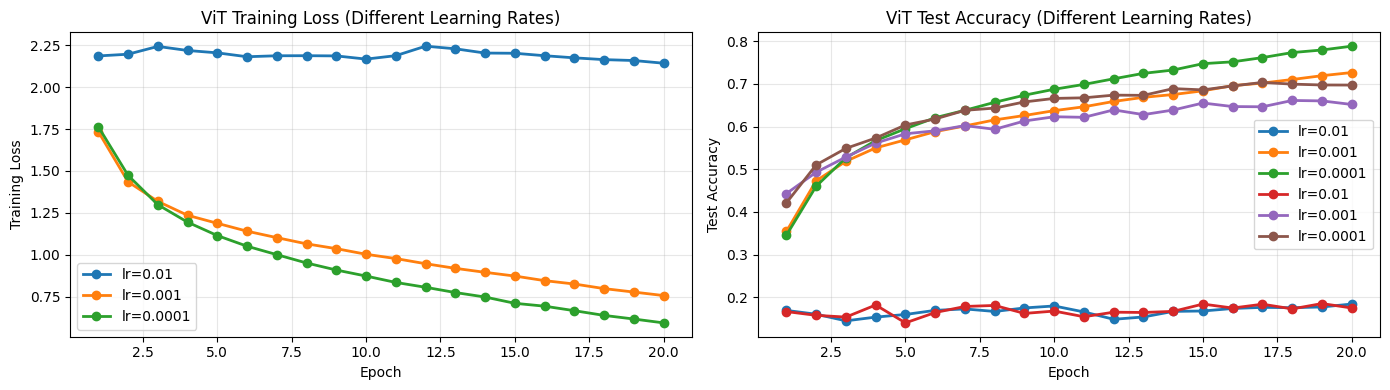


Summary - Final Test Accuracy:
Learning Rate 0.01: 0.1747
Learning Rate 0.001: 0.6518
Learning Rate 0.0001: 0.6973


In [23]:
# Test ViT with different learning rates for batch size = 64
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr_test in learning_rates:
    print(f"\n{'='*60}")
    print(f"Training ViT with learning rate = {lr_test}")
    print(f"{'='*60}")

    # Create new model with current learning rate
    vit_model = VisionTransformer().to(device)
    vit_criterion = nn.CrossEntropyLoss()
    vit_optimizer = optim.Adam(vit_model.parameters(), lr=lr_test)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs_cifar):
        vit_model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in cifar_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            vit_optimizer.zero_grad()
            outputs = vit_model(inputs)
            loss = vit_criterion(outputs, labels)
            loss.backward()
            vit_optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on test set
        vit_model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in cifar_test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = vit_model(inputs)
                _, preds = outputs.max(1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs_cifar}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")

    results[lr_test] = {'train_losses': train_losses, 'train_accs': train_accs, 'test_accs': test_accs}

# Plot comparison of different learning rates
epochs_range = np.arange(1, num_epochs_cifar + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot training loss
for lr_test in learning_rates:
    axes[0].plot(epochs_range, results[lr_test]['train_losses'],  marker='o', linewidth=2, label=f'lr={lr_test}')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("ViT Training Loss (Different Learning Rates)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#Plot training accuracy
for lr_test in learning_rates:
    axes[1].plot(epochs_range, results[lr_test]['train_accs'],  marker='o', linewidth=2, label=f'lr={lr_test}')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Train Accuracy")
axes[1].set_title("ViT Train Accuracy (Different Learning Rates)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot test accuracy
for lr_test in learning_rates:
    axes[2].plot(epochs_range, results[lr_test]['test_accs'],  marker='o', linewidth=2, label=f'lr={lr_test}')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("ViT Test Accuracy (Different Learning Rates)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("Summary - Final Test Accuracy:")
print(f"{'='*60}")
for lr_test in learning_rates:
    final_acc = results[lr_test]['test_accs'][-1]
    print(f"Learning Rate {lr_test}: {final_acc:.4f}")

In [24]:
# Average accuracies
for lr_test in learning_rates:
  avg_acc = sum(results[lr_test]['test_accs'])/len(results[lr_test]['test_accs'])
  print(f"Learning Rate {lr_test}: {avg_acc:.4f}")

Learning Rate 0.01: 0.1688
Learning Rate 0.001: 0.6040
Learning Rate 0.0001: 0.6381


Training ViT with RMSProp optimizer (lr=0.0001)...
Epoch 01/20  train_loss=1.7535  train_acc=0.3505  test_acc=0.3787
Epoch 02/20  train_loss=1.4974  train_acc=0.4560  test_acc=0.4546
Epoch 03/20  train_loss=1.3534  train_acc=0.5083  test_acc=0.5056
Epoch 04/20  train_loss=1.2549  train_acc=0.5445  test_acc=0.5082
Epoch 05/20  train_loss=1.1732  train_acc=0.5752  test_acc=0.5623
Epoch 06/20  train_loss=1.1086  train_acc=0.6000  test_acc=0.5640
Epoch 07/20  train_loss=1.0577  train_acc=0.6180  test_acc=0.6158
Epoch 08/20  train_loss=1.0089  train_acc=0.6349  test_acc=0.5853
Epoch 09/20  train_loss=0.9679  train_acc=0.6522  test_acc=0.6286
Epoch 10/20  train_loss=0.9260  train_acc=0.6683  test_acc=0.6280
Epoch 11/20  train_loss=0.8908  train_acc=0.6838  test_acc=0.6209
Epoch 12/20  train_loss=0.8526  train_acc=0.6951  test_acc=0.5876
Epoch 13/20  train_loss=0.8281  train_acc=0.7033  test_acc=0.6505
Epoch 14/20  train_loss=0.7977  train_acc=0.7144  test_acc=0.6558
Epoch 15/20  train_loss=0

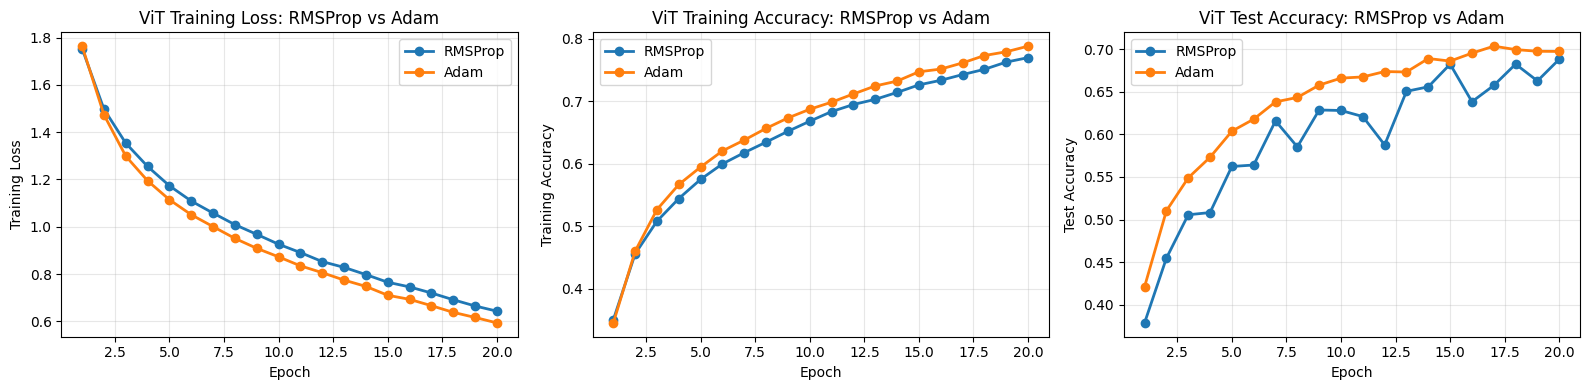


Summary - RMSProp vs Adam Optimizer Comparison (lr=0.0001):

RMSProp:
  Final Train Accuracy: 0.7701
  Final Test Accuracy:  0.6882
  Final Train Loss:     0.6430

Adam:
  Final Train Accuracy: 0.7885
  Final Test Accuracy:  0.6973
  Final Train Loss:     0.5933


In [25]:
# Based on the results, lr=0.0001 was the best learning rate (avg test accuracy of 0.64)
# Now train ViT with RMSProp optimizer using the best learning rate

best_lr = 0.0001
print(f"Training ViT with RMSProp optimizer (lr={best_lr})...")
print(f"{'='*60}")

vit_model_rmsprop = VisionTransformer().to(device)
vit_criterion_rmsprop = nn.CrossEntropyLoss()
vit_optimizer_rmsprop = optim.RMSprop(vit_model_rmsprop.parameters(), lr=best_lr)

rmsprop_train_losses = []
rmsprop_train_accs = []
rmsprop_test_accs = []

for epoch in range(num_epochs_cifar):
    vit_model_rmsprop.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in cifar_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        vit_optimizer_rmsprop.zero_grad()
        outputs = vit_model_rmsprop(inputs)
        loss = vit_criterion_rmsprop(outputs, labels)
        loss.backward()
        vit_optimizer_rmsprop.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    rmsprop_train_losses.append(train_loss)
    rmsprop_train_accs.append(train_acc)

    # Evaluate on test set
    vit_model_rmsprop.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in cifar_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_model_rmsprop(inputs)
            _, preds = outputs.max(1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    rmsprop_test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs_cifar}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")

# Plot results comparing RMSProp with Adam (lr=0.001)
epochs_range = np.arange(1, num_epochs_cifar + 1)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot training loss
axes[0].plot(epochs_range, rmsprop_train_losses, marker='o', linewidth=2, label='RMSProp')
axes[0].plot(epochs_range, results[best_lr]['train_losses'], marker='o', linewidth=2, label='Adam')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("ViT Training Loss: RMSProp vs Adam")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot training accuracy
axes[1].plot(epochs_range, rmsprop_train_accs, marker='o', linewidth=2, label='RMSProp')
axes[1].plot(epochs_range, results[best_lr]['train_accs'], marker='o', linewidth=2, label='Adam')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Accuracy")
axes[1].set_title("ViT Training Accuracy: RMSProp vs Adam")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot test accuracy
axes[2].plot(epochs_range, rmsprop_test_accs, marker='o', linewidth=2, label='RMSProp')
axes[2].plot(epochs_range, results[best_lr]['test_accs'], marker='o', linewidth=2, label='Adam')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("ViT Test Accuracy: RMSProp vs Adam")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary and observations
print(f"\n{'='*60}")
print("Summary - RMSProp vs Adam Optimizer Comparison (lr=0.0001):")
print(f"{'='*60}")
print(f"\nRMSProp:")
print(f"  Final Train Accuracy: {rmsprop_train_accs[-1]:.4f}")
print(f"  Final Test Accuracy:  {rmsprop_test_accs[-1]:.4f}")
print(f"  Final Train Loss:     {rmsprop_train_losses[-1]:.4f}")

print(f"\nAdam:")
print(f"  Final Train Accuracy: {results[best_lr]['train_accs'][-1]:.4f}")
print(f"  Final Test Accuracy:  {results[best_lr]['test_accs'][-1]:.4f}")
print(f"  Final Train Loss:     {results[best_lr]['train_losses'][-1]:.4f}")




Training ViT with 4 Transformer layers
Epoch 01/20  train_loss=1.6949  train_acc=0.3724  test_acc=0.4534
Epoch 02/20  train_loss=1.4017  train_acc=0.4879  test_acc=0.5260
Epoch 03/20  train_loss=1.2895  train_acc=0.5305  test_acc=0.5354
Epoch 04/20  train_loss=1.2196  train_acc=0.5559  test_acc=0.5684
Epoch 05/20  train_loss=1.1723  train_acc=0.5759  test_acc=0.5864
Epoch 06/20  train_loss=1.1227  train_acc=0.5925  test_acc=0.5888
Epoch 07/20  train_loss=1.0840  train_acc=0.6102  test_acc=0.6047
Epoch 08/20  train_loss=1.0517  train_acc=0.6204  test_acc=0.6006
Epoch 09/20  train_loss=1.0179  train_acc=0.6334  test_acc=0.6164
Epoch 10/20  train_loss=0.9858  train_acc=0.6468  test_acc=0.6185
Epoch 11/20  train_loss=0.9599  train_acc=0.6535  test_acc=0.6352
Epoch 12/20  train_loss=0.9320  train_acc=0.6634  test_acc=0.6314
Epoch 13/20  train_loss=0.9006  train_acc=0.6748  test_acc=0.6348
Epoch 14/20  train_loss=0.8801  train_acc=0.6821  test_acc=0.6380
Epoch 15/20  train_loss=0.8484  trai

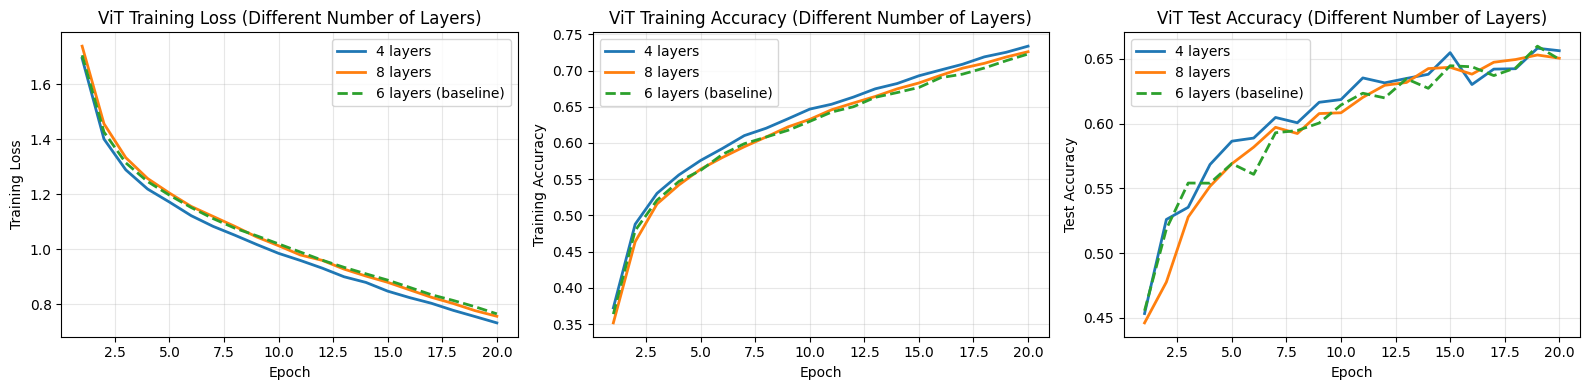


Summary - Effect of Number of Transformer Layers:

4 Layers:
  Final Train Loss:     0.7329
  Final Train Accuracy: 0.7337
  Final Test Accuracy:  0.6562

6 Layers:
  Final Train Loss:     0.7658
  Final Train Accuracy: 0.7228
  Final Test Accuracy:  0.6496

8 Layers:
  Final Train Loss:     0.7569
  Final Train Accuracy: 0.7260
  Final Test Accuracy:  0.6504


In [26]:
# Investigate the effect of different numbers of Transformer layers (4 and 8)
num_layers_list = [4, 8]
layer_results = {}

for num_layers_vit in num_layers_list:
    print(f"\n{'='*60}")
    print(f"Training ViT with {num_layers_vit} Transformer layers")
    print(f"{'='*60}")

    # Create new model with different number of layers
    vit_model_layers = VisionTransformer(in_channels=3, patch_size=4, emb_size=128, img_size=32,
                                         num_heads=4, num_layers=num_layers_vit, num_classes=10, dropout=0.1).to(device)
    vit_criterion_layers = nn.CrossEntropyLoss()
    vit_optimizer_layers = optim.Adam(vit_model_layers.parameters(), lr=lr_cifar)

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs_cifar):
        vit_model_layers.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in cifar_train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            vit_optimizer_layers.zero_grad()
            outputs = vit_model_layers(inputs)
            loss = vit_criterion_layers(outputs, labels)
            loss.backward()
            vit_optimizer_layers.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on test set
        vit_model_layers.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in cifar_test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = vit_model_layers(inputs)
                _, preds = outputs.max(1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1:02d}/{num_epochs_cifar}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  test_acc={test_acc:.4f}")

    layer_results[num_layers_vit] = {'train_losses': train_losses, 'train_accs': train_accs, 'test_accs': test_accs}

# Plot comparison of different number of layers
epochs_range = np.arange(1, num_epochs_cifar + 1)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot training loss
for num_layers_vit in num_layers_list:
    axes[0].plot(epochs_range, layer_results[num_layers_vit]['train_losses'], linewidth=2, label=f'{num_layers_vit} layers')
axes[0].plot(epochs_range, vit_train_losses, linewidth=2, linestyle='--', label='6 layers (baseline)')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("ViT Training Loss (Different Number of Layers)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot training accuracy
for num_layers_vit in num_layers_list:
    axes[1].plot(epochs_range, layer_results[num_layers_vit]['train_accs'], linewidth=2, label=f'{num_layers_vit} layers')
axes[1].plot(epochs_range, vit_train_accs, linewidth=2, linestyle='--', label='6 layers (baseline)')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Training Accuracy")
axes[1].set_title("ViT Training Accuracy (Different Number of Layers)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot test accuracy
for num_layers_vit in num_layers_list:
    axes[2].plot(epochs_range, layer_results[num_layers_vit]['test_accs'], linewidth=2, label=f'{num_layers_vit} layers')
axes[2].plot(epochs_range, vit_test_accs, linewidth=2, linestyle='--', label='6 layers (baseline)')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Test Accuracy")
axes[2].set_title("ViT Test Accuracy (Different Number of Layers)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary and discussion
print(f"\n{'='*60}")
print("Summary - Effect of Number of Transformer Layers:")
print(f"{'='*60}")

results_summary = {
    6: {'train_loss': vit_train_losses[-1], 'train_acc': vit_train_accs[-1], 'test_acc': vit_test_accs[-1]},
    4: {'train_loss': layer_results[4]['train_losses'][-1], 'train_acc': layer_results[4]['train_accs'][-1], 'test_acc': layer_results[4]['test_accs'][-1]},
    8: {'train_loss': layer_results[8]['train_losses'][-1], 'train_acc': layer_results[8]['train_accs'][-1], 'test_acc': layer_results[8]['test_accs'][-1]}
}

for num_layers_vit in [4, 6, 8]:
    print(f"\n{num_layers_vit} Layers:")
    print(f"  Final Train Loss:     {results_summary[num_layers_vit]['train_loss']:.4f}")
    print(f"  Final Train Accuracy: {results_summary[num_layers_vit]['train_acc']:.4f}")
    print(f"  Final Test Accuracy:  {results_summary[num_layers_vit]['test_acc']:.4f}")
